# Simulator Response Comparison -- Vogels-Abbott Benchmark

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import ks_2samp, pearsonr

In [2]:
plt.style.use('seaborn-paper')
SMALL_SIZE = 35
MEDIUM_SIZE = 45
BIGGER_SIZE = 45

plt.rc('font', size=SMALL_SIZE, family="Arial")          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', color="black")          # controls default text sizes

plt.rcParams['axes.linewidth'] = 5.0
plt.rcParams['figure.figsize'] = (20.0, 10.0)


%matplotlib inline

### Loading Auryn firing times

In [3]:
ls ../auryn/coba.0*

../auryn/coba.0.e.ras  ../auryn/coba.0.i.ras


In [4]:
auryn_df = pd.read_csv("../auryn/coba.0.e.ras", delim_whitespace=True, header=None, names=["times", "ids"])

In [5]:
auryn_data = {
    "name": "Auryn",
    "spikes": auryn_df,
}

### Loading Nest firing times

In [6]:
ls ../pyNest/

Build/  COBA.py  setpaths.sh*  timefile.dat  va-py-ex-4001-0.gdf


In [7]:
nest_df = pd.read_csv("../pyNest/va-py-ex-4001-0.gdf", delim_whitespace=True, header=None, names=["ids", "times"])

In [8]:
# Bring nest timing into seconds
nest_df["times"] /= 1000.0
nest_df["ids"] -= 1

In [9]:
nest_data = {
    "name": "NEST",
    "spikes": nest_df,
}

### Loading Spike firing times

In [10]:
ls ../Spike/Build/

CMakeCache.txt  cmake_install.cmake  timefile.dat    VASpikeTimes.bin
CMakeFiles/     Makefile             VASpikeIDs.bin  VogelsAbbottNet*


In [11]:
idsfile = "../Spike/Build/VASpikeIDs.bin"
timesfile = "../Spike/Build/VASpikeTimes.bin"
spike_df = pd.DataFrame(data = {"ids": np.fromfile(idsfile, dtype=np.int32), "times": np.fromfile(timesfile, dtype=np.float32)})

In [12]:
spike_data = {
    "name": "Spike",
    "spikes": spike_df
}

### Loading ANNarchy firing times

In [13]:
ls ../ANNarchy/

annarchy/  COBA.py  spikes.out  timefile.dat


In [14]:
spikesfile = "../ANNarchy/spikes.out"
annarchy_df = pd.read_csv(spikesfile, delim_whitespace=True, header=None, names=["ids", "times"])

In [15]:
# Bring ANNarchy timing into seconds
annarchy_df["times"] /= 10000.0

In [16]:
annarchy_data = {
    "name": "ANNarchy",
    "spikes": annarchy_df
}

### Loading Brian2 firing times

In [17]:
ls ../brian2/

COBA.py  output/  spikes.out  timefile.dat


In [18]:
spikesfile = "../brian2/spikes.out"
brian2_df = pd.read_csv(spikesfile, delim_whitespace=True, header=None, names=["ids", "times"])

In [19]:
brian2_data = {
    "name": "Brian2",
    "spikes": brian2_df
}

### Loading GeNN firing times

In [20]:
ls ../genn/*.csv

../genn/spikes.csv


In [21]:
spikesfile = "../genn/spikes.csv"
genn_df = pd.read_csv(spikesfile)
genn_df = genn_df.rename(index=str, columns={" Neuron ID": "ids", "Time [ms]": "times"})

In [22]:
# Bring timing into seconds
genn_df["times"] /= 10000.0

In [23]:
genn_data = {
    "name": "GeNN",
    "spikes": genn_df,
}

## Comparing Simulators

In [24]:
simulator_data = [
    nest_data,
    spike_data,
    auryn_data,
    annarchy_data,
    brian2_data,
    genn_data
]

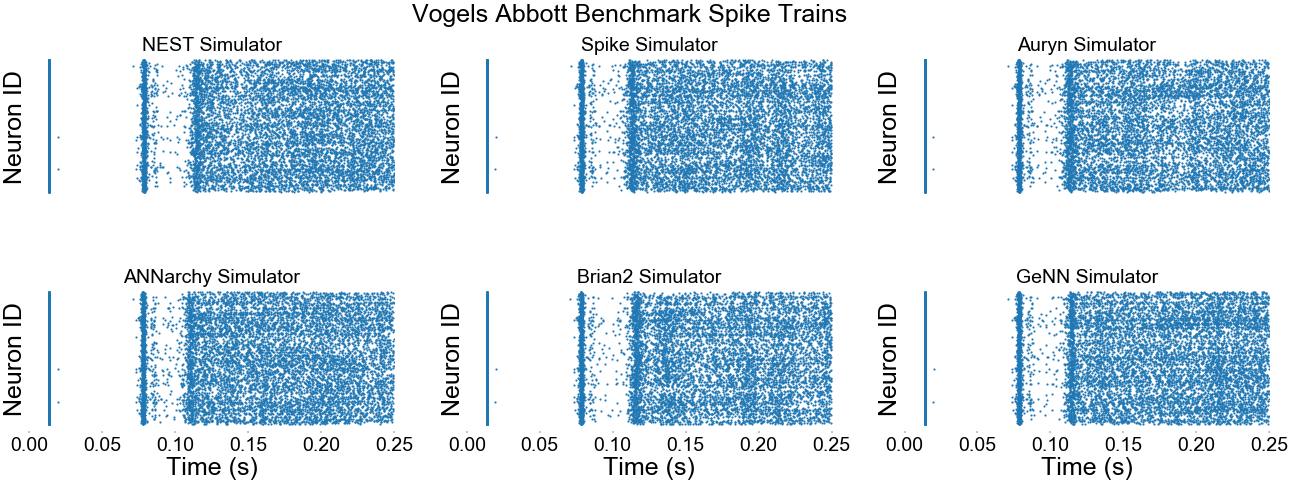

In [25]:
fig = plt.figure(figsize=(40, 12.5), dpi=40)
starttime = 0.0
endtime = 0.25

for index, data in enumerate(simulator_data):
    ax = plt.subplot(2, len(simulator_data) / 2, index + 1)
    mask = (data["spikes"]["times"] > starttime) & (data["spikes"]["times"] < endtime) & (data["spikes"]["ids"] < 3200)
    ax.scatter(data["spikes"]["times"][mask], data["spikes"]["ids"][mask], marker='.', s=50)
    ax.set_title(data["name"] + " Simulator")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Neuron ID")
    ax.set_yticks([])
    if (index < len(simulator_data) / 2):
        ax.set_xticks([])
        ax.set_xlabel("")
    ax.set_xlim([starttime, endtime])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
plt.subplots_adjust(hspace=0.6)

_ = fig.suptitle('Vogels Abbott Benchmark Spike Trains')

## Firing Rate Analysis

In [26]:
colours = plt.rcParams['axes.prop_cycle'].by_key()['color'] #['red', 'green', 'blue', 'orange', 'magenta', 'black']

In [27]:
numberoftimesamples = 10
timesamplewidth = 10.0
timeintervalstarts = []

np.random.seed(42)
for t in range(numberoftimesamples):
    starttime = np.random.rand()*(100.0 - timesamplewidth)
    timeintervalstarts.append(starttime)

In [28]:
rates = [[] for t in range(numberoftimesamples)]
numexcneurons = 3200

for t in range(numberoftimesamples):
    for index, data in enumerate(simulator_data):
        mask = (data["spikes"]["times"] >= timeintervalstarts[t]) & (data["spikes"]["times"] < (timeintervalstarts[t] + timesamplewidth)) & (data["spikes"]["ids"] < numexcneurons)
        selectedids = data["spikes"]["ids"][mask]
#         rates[t].append(get_rates(selectedids, data["spikes"]["times"][mask]))
        rates[t].append(np.bincount(selectedids, minlength=numexcneurons) / timesamplewidth)

In [29]:
binvalues = np.linspace(0.0, 50.0, 11)

ratehistograms = [[] for t in range(numberoftimesamples)]
for t in range(numberoftimesamples):
    for index, data in enumerate(simulator_data):
        ratehistograms[t].append(np.histogram(rates[t][index], bins=binvalues)[0])

In [30]:
np.asarray(ratehistograms).shape

(10, 6, 10)

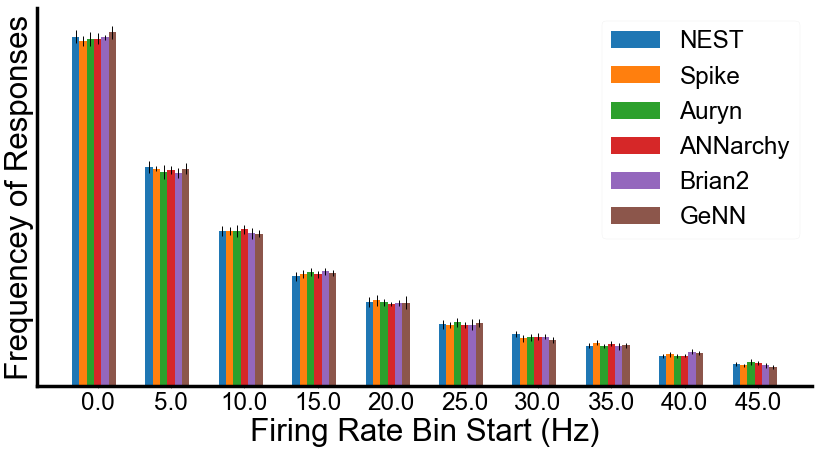

In [31]:
# Plotting histograms using mean and standard deviation
plt.figure(figsize=(20,10), dpi=50)

for index, data in enumerate(simulator_data):
    for b_index in range(len(binvalues) - 1):
        kwargs = {"alpha": 1.0, "width":0.1, "color": colours[index]}
        if (b_index == 0):
            kwargs["label"] = data["name"]
        plt.bar([b_index + index*0.1], [np.mean(np.asarray(ratehistograms), axis=0)[index][b_index]], yerr=[np.std(np.asarray(ratehistograms), axis=0)[index][b_index]], **kwargs)

plt.xticks(np.arange(len(binvalues) - 1) + 0.5*0.1*len(simulator_data), binvalues[:-1])
plt.yticks([])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel("Frequencey of Responses")
plt.xlabel("Firing Rate Bin Start (Hz)")
plt.legend()

### Analysing Correlation and K-S Distributions

Pearson Correlation:

In [32]:
rate_correlations = np.zeros((len(simulator_data), len(simulator_data), numberoftimesamples, numberoftimesamples))

for s1 in range(len(simulator_data)):
    for s2 in range(len(simulator_data)):
        for t1 in range(numberoftimesamples):
            for t2 in range(numberoftimesamples):
                rate_correlations[s1,s2,t1,t2] = pearsonr(rates[t1][s1], rates[t2][s2])[0]

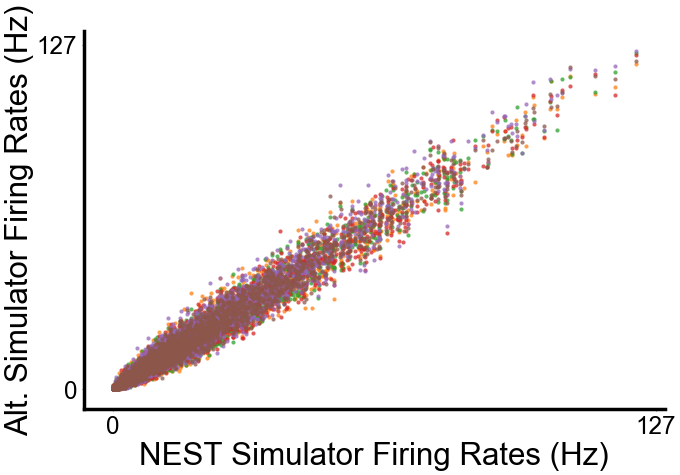

In [33]:
plt.figure(figsize=(15,10), dpi=50)

for index, data in enumerate(simulator_data):
    if (index == 0):
        continue
    plt.scatter(rates[0][0], rates[0][index], color=colours[index], alpha=0.75)

plt.ylabel("Alt. Simulator Firing Rates (Hz)")
plt.xlabel("NEST Simulator Firing Rates (Hz)")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

_ = plt.xticks([0.0, np.max(rates)])
_ = plt.yticks([0.0, np.max(rates)])

In [34]:
# Minimum R^2 value for all combinations
np.min(rate_correlations)

0.97902788123591411

Kolmogorov-Smirnov 2 Sample Testing

In [35]:
rate_ks = np.zeros((len(simulator_data), len(simulator_data), numberoftimesamples, numberoftimesamples))

for s1 in range(len(simulator_data)):
    for s2 in range(len(simulator_data)):
        for t1 in range(numberoftimesamples):
            for t2 in range(numberoftimesamples):
                rate_ks[s1,s2,t1,t2] = ks_2samp(rates[t1][s1],rates[t2][s2])[1]

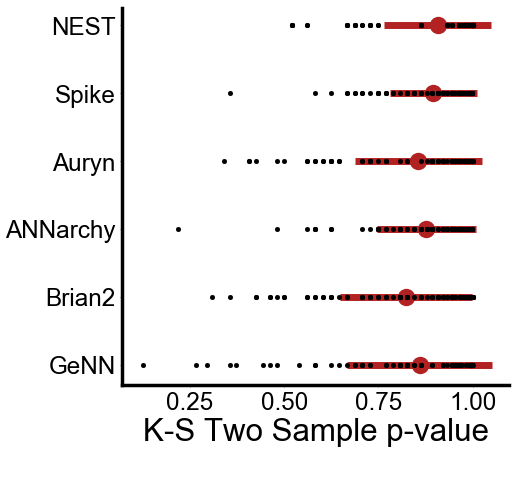

In [36]:
# %%capture
plt.figure(figsize=(10,10), dpi=50)

tickvalues = []
count = 0
for s1 in range(len(simulator_data[:1])):
    for s2 in np.arange(s1,len(simulator_data)):
        plt.errorbar(np.mean(rate_ks[s1,s2]), [-1*count], fmt=".", ms=50, lw=10, color='firebrick', xerr=np.std(rate_ks[s1,s2].flatten()), zorder=-1)
        plt.scatter(rate_ks[s1,s2].flatten(), -1*count*np.ones(rate_ks[s1,s2].flatten().shape), s=50, color='k')
        tickvalues.append(simulator_data[s2]["name"])
        count += 1
        
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("K-S Two Sample p-value\n")
_ = plt.yticks(-1*np.arange(count), tickvalues, rotation='horizontal')

## ISI Analysis

In [37]:
numberoftimesamples = 10
timesamplewidth = 30.0
timeintervalstarts = []
mintime=20.0

np.random.seed(42)
for t in range(numberoftimesamples):
    starttime = mintime + np.random.rand()*((100.0 - mintime) - timesamplewidth)
    timeintervalstarts.append(starttime)

In [38]:
def ISICalc(ids, times, numneurons):
    ISIs = []
    for n in range(numneurons):
        subtimes = times[ids == n]
        if (len(subtimes) > 1):
            ISIs.append(subtimes[1:] - subtimes[0:-1])
        else:
            ISIs.append([])
    return(ISIs)

In [39]:
def CVISICalc(ISIs):
    CVs = []
    for ISI in ISIs:
        if (len(ISI) > 0):
            CVs.append(np.std(ISI) / np.mean(ISI))
    return(np.asarray(CVs))

In [40]:
ISIs = [[] for t in range(numberoftimesamples)]
numexcneurons = 3200

for t in range(numberoftimesamples):
    for index, data in enumerate(simulator_data):
        mask = (data["spikes"]["times"] >= timeintervalstarts[t]) & (data["spikes"]["times"] < (timeintervalstarts[t] + timesamplewidth)) & (data["spikes"]["ids"] < numexcneurons)
        selectedids = data["spikes"]["ids"][mask]
        selectedtimes = data["spikes"]["times"][mask]
        ISIs[t].append(ISICalc(selectedids.values, selectedtimes.values, numexcneurons))

In [41]:
CVs = [[] for t in range(numberoftimesamples)]
numexcneurons = 3200

for t in range(numberoftimesamples):
    for index, data in enumerate(simulator_data):
        CVs[t].append(CVISICalc(ISIs[t][index]))

In [42]:
np.asarray(ISIs).shape, np.asarray(CVs).shape

((10, 6, 3200), (10, 6))

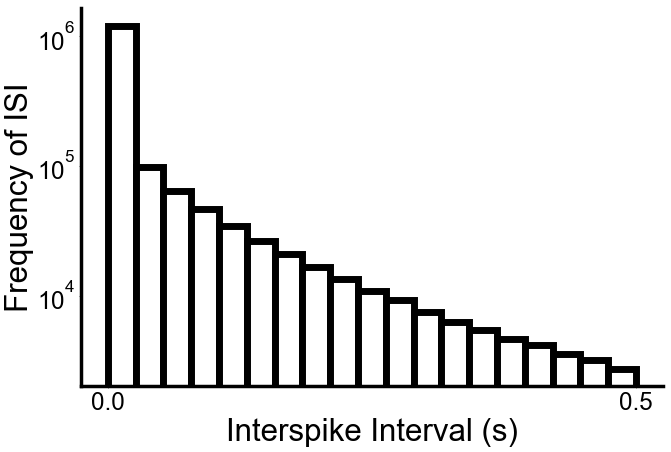

In [43]:
plt.figure(figsize=(15,10), dpi=50)

binvalues = np.linspace(0,0.50,20)
dashes = [2, 2, 4, 4]

plt.hist(np.concatenate(ISIs[0][0], axis=0), bins=binvalues, color='white', edgecolor='k', lw=10) #,  histtype='step', lw=5.0, ls=(5*index, dashes))

plt.yscale('log')
plt.ylabel("Frequency of ISI")
plt.xlabel("Interspike Interval (s)")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

_ = plt.xticks([np.min(binvalues), np.max(binvalues)])

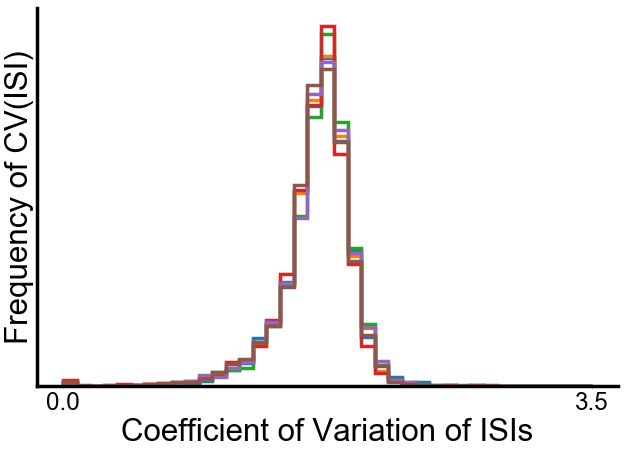

In [44]:
plt.figure(figsize=(15,10), dpi=50)

binvalues = np.linspace(0,3.5,40)
dashes = [2, 2, 4, 4]

# plt.hist(CVs[0][0], bins=binvalues, color='white', edgecolor='k', lw=10) #,  histtype='step', lw=5.0, ls=(5*index, dashes))
for index, data in enumerate(simulator_data):
    dashes = (2.5, 5)
    _ = plt.hist(CVs[0][index], bins=binvalues, color=colours[index],  histtype='step', lw=5.0)

# plt.yscale('log')
plt.ylabel("Frequency of CV(ISI)")
plt.xlabel("Coefficient of Variation of ISIs")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.yticks([])
_ = plt.xticks([np.min(binvalues), np.max(binvalues)])

In [45]:
CV_ks = np.zeros((len(simulator_data), len(simulator_data), numberoftimesamples, numberoftimesamples))

for s1 in range(len(simulator_data)):
    for s2 in range(len(simulator_data)):
        for t1 in range(numberoftimesamples):
            for t2 in range(numberoftimesamples):
                sample1 = CVs[t1][s1]
                sample2 = CVs[t2][s2]
                CV_ks[s1,s2,t1,t2] = ks_2samp(sample1,sample2)[1]

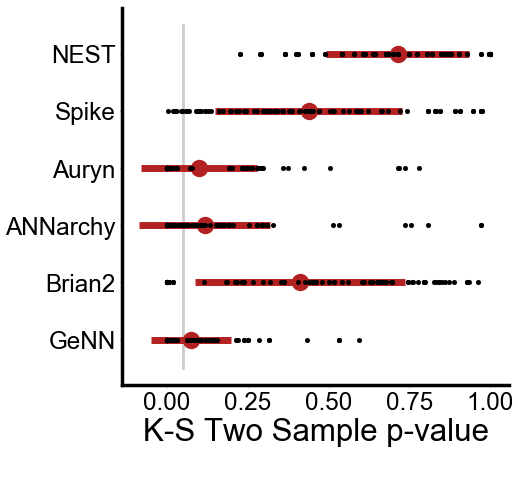

In [46]:
# %%capture
plt.figure(figsize=(10,10), dpi=50)

tickvalues = []
count = 0
for s1 in range(len(simulator_data[:1])):
    for s2 in np.arange(s1,len(simulator_data)):
        plt.errorbar(np.mean(CV_ks[s1,s2]), [-1*count], fmt=".", ms=50, lw=10, color='firebrick', xerr=np.std(CV_ks[s1,s2].flatten()), zorder=-1)
        plt.scatter(CV_ks[s1,s2].flatten(), -1*count*np.ones(CV_ks[s1,s2].flatten().shape), s=50, color='k')
        tickvalues.append(simulator_data[s2]["name"])
        count += 1
        
plt.plot([0.05, 0.05], [0.5,-5.5], lw=4, zorder=-5, color='k', alpha=0.2)
        
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("K-S Two Sample p-value\n")
_ = plt.yticks(-1*np.arange(count), tickvalues, rotation='horizontal')